In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class Model:
    def __init__(self, **kwargs):
        for key in kwargs.keys():
            self.__setattr__(key, kwargs.get(key))  
        self.info = {
            'k-boss':{                
                'prop':{
                    'k':[],
                    'n':[],
                },
                'gamma':{
                    'k':[],
                    'n':[],
                },
                'q':{
                    'k':[],
                    'n':[],
                },
                'dU':{
                    'k':[],
                    'n':[],
                },
            }, 
            'n-boss':{   
                'prop':{
                    'k':[],
                    'n':[],
                },             
                'gamma':{
                    'k':[],
                    'n':[],
                },
                'q':{
                    'k':[],
                    'n':[],
                },
                'dU':{
                    'k':[],
                    'n':[],
                },
            }, 
        } 

        self.p_k = self.p_n - self.delta_p
        self.k = self.m * self.alpha_k
        self.n = self.m - self.k
        delta = self.alpha_k - self.alpha_n
        self.beta = (1 - self.alpha_k) / (1 - delta)
        self.P = np.array([[self.alpha_k, self.alpha_n], [1 - self.alpha_k, 1 - self.alpha_n]])
        self.validness = self.check_validness()
    
    def check_validness(self):
        if (
                1 == 1
                # and self.w_0 >= 0
                and self.alpha_k >= 0 and self.alpha_k <= 1
                and self.alpha_n >= 0 and self.alpha_n <= 1
                and self.alpha_k >= self.alpha_n 
                and self.p_n >= 0 and self.p_n <= 1
                and self.p_k >= 0 and self.p_k <= 1
                and self.p_n >= self.p_k
                and self.lambda_k >= 1
                and self.lambda_n >= 1 
                and self.lambda_k >= self.lambda_n
                and self.l >= 1
                and self.m >= 1
            ):
            return True
        return False

    def compute_gamma(self):
        P_numerator = np.identity(2)
        P_denominator = self.P
        gamma_matrix_list = []
        gamma_matrix_list.append(np.zeros((2, 2)))
        prop_matrix_list = []
        prop_matrix_list.append(np.identity(2))
        for i in range(self.l - 1):
            gamma_matrix_list.append(P_numerator / P_denominator / self.m)
            prop_matrix_list.append(P_denominator)
            P_numerator = P_numerator @ self.P
            P_denominator = P_denominator @ self.P
        
        for gamma_matrix, prop_matrix in zip(gamma_matrix_list[::-1], prop_matrix_list[::-1]):
            self.info['k-boss']['gamma']['k'].append(gamma_matrix[0, 0])
            self.info['k-boss']['gamma']['n'].append(gamma_matrix[1, 0])
            self.info['n-boss']['gamma']['k'].append(gamma_matrix[0, 1])
            self.info['n-boss']['gamma']['n'].append(gamma_matrix[1, 1])
            
            self.info['k-boss']['prop']['k'].append(prop_matrix[0, 0])
            self.info['k-boss']['prop']['n'].append(prop_matrix[1, 0])
            self.info['n-boss']['prop']['k'].append(prop_matrix[0, 1])
            self.info['n-boss']['prop']['n'].append(prop_matrix[1, 1])
    
    def compute_q(self):
        q_k = [0]
        q_n = [0]
        for i in range(self.l - 1)[::-1]:
            q_k.append((1 - self.p_k + self.p_k * q_k[-1]) * self.info['k-boss']['gamma']['k'][i])
            q_n.append((1 - self.p_n + self.p_n * q_n[-1]) * self.info['k-boss']['gamma']['n'][i])
        self.info['k-boss']['q']['k'] = q_k[::-1]
        self.info['k-boss']['q']['n'] = q_n[::-1]
        q_k = [0]
        q_n = [0]
        for i in range(self.l - 1)[::-1]:
            q_k.append((1 - self.p_k + self.p_k * q_k[-1]) * self.info['n-boss']['gamma']['k'][i])
            q_n.append((1 - self.p_n + self.p_n * q_n[-1]) * self.info['n-boss']['gamma']['n'][i])
        self.info['n-boss']['q']['k'] = q_k[::-1]
        self.info['n-boss']['q']['n'] = q_n[::-1]
    
    def compute_U(self):
        U_k = [0]
        U_n = [0]
        for i in range(self.l)[::-1]:
            U_k.append(self.p_k * (1 - self.p_k + self.p_k * self.info['k-boss']['q']['k'][i]) *\
                (self.lambda_k**i + self.info['k-boss']['q']['k'][i] * U_k[-1]))
            U_n.append(self.p_n * (1 - self.p_n + self.p_n * self.info['k-boss']['q']['n'][i]) *\
                (self.lambda_n**i + self.info['k-boss']['q']['n'][i] * U_n[-1]))
        self.info['k-boss']['dU']['k'] = [U_k[i] / U_k[i + 1] for i in range(1, self.l)][::-1]
        self.info['k-boss']['dU']['n'] = [U_n[i] / U_n[i + 1] for i in range(1, self.l)][::-1]
        # self.info['k-boss']['dU']['n'] = U_n[1:][::-1]
        U_k = [0]
        U_n = [0]
        for i in range(self.l)[::-1]:
            U_k.append(self.p_k * (1 - self.p_k + self.p_k * self.info['n-boss']['q']['k'][i]) *\
                (self.lambda_k**i + self.info['n-boss']['q']['k'][i] * U_k[-1]))
            U_n.append(self.p_n * (1 - self.p_n + self.p_n * self.info['n-boss']['q']['n'][i]) *\
                (self.lambda_n**i + self.info['n-boss']['q']['n'][i] * U_n[-1]))
        self.info['n-boss']['dU']['k'] = [U_k[i] / U_k[i + 1] for i in range(1, self.l)][::-1]
        self.info['n-boss']['dU']['n'] = [U_n[i] / U_n[i + 1] for i in range(1, self.l)][::-1]

    def compute_model(self):
        self.compute_gamma()
        self.compute_q()
        self.compute_U()
    
    def test_q_dynamic_k_boss_k(self):
        phase_increase_k_boss_k = True
        prev_k_boss_k = 0
        for i in range(self.l):
            if np.isclose(self.info['k-boss']['q']['k'][i], prev_k_boss_k):
                continue
            if phase_increase_k_boss_k:
                if self.info['k-boss']['q']['k'][i] < prev_k_boss_k:
                    phase_increase_k_boss_k = False
            else:
                if self.info['k-boss']['q']['k'][i] > prev_k_boss_k:
                    return False
            prev_k_boss_k = self.info['k-boss']['q']['k'][i]

        return True
    
    def test_q_dynamic_n_boss_n(self):
        phase_increase_n_boss_n = True
        prev_n_boss_n = 0
        for i in range(self.l):
            if np.isclose(self.info['n-boss']['q']['n'][i], prev_n_boss_n):
                continue
            if phase_increase_n_boss_n:
                if self.info['n-boss']['q']['n'][i] < prev_n_boss_n:
                    phase_increase_n_boss_n = False
            else:
                if self.info['n-boss']['q']['n'][i] > prev_n_boss_n:
                    return False
            prev_n_boss_n = self.info['n-boss']['q']['n'][i]

        return True

    def test_q_dynamic_k_boss_n(self):
        prev = 1
        for i in range(self.l):
            if np.isclose(self.info['k-boss']['q']['n'][i], prev):
                continue
            if self.info['k-boss']['q']['n'][i] > prev:
                return False
            prev = self.info['k-boss']['q']['n'][i]

        return True

    def test_q_dynamic_n_boss_k(self):
        prev = 1
        for i in range(self.l):
            if np.isclose(self.info['n-boss']['q']['k'][i], prev):
                continue
            if self.info['n-boss']['q']['k'][i] > prev:
                return False
            prev = self.info['n-boss']['q']['k'][i]

        return True


    def test_U_dynamic_k_boss_k(self):
        '''
        Does not work
        '''
        phase_increase_k_boss_k = True
        prev_k_boss_k = 0
        for i in range(self.l - 1):
            if np.isclose(self.info['k-boss']['dU']['k'][i], prev_k_boss_k):
                continue
            if phase_increase_k_boss_k:
                if self.info['k-boss']['dU']['k'][i] < prev_k_boss_k:
                    phase_increase_k_boss_k = False
            else:
                if self.info['k-boss']['dU']['k'][i] > prev_k_boss_k:
                    return False
            prev_k_boss_k = self.info['k-boss']['dU']['k'][i]

        return True
    
    def test_U_dynamic_n_boss_n(self):
        '''
        Does not work
        '''
        prev = np.inf
        for i in range(self.l - 1):
            if np.isclose(self.info['n-boss']['dU']['n'][i], prev):
                continue
            if self.info['n-boss']['dU']['n'][i] > prev:
                return False
            prev = self.info['n-boss']['dU']['n'][i]

        return True

    def test_U_dynamic_k_boss_n(self):
        prev = np.inf
        for i in range(self.l - 2):
            if np.isclose(self.info['k-boss']['dU']['n'][i], prev):
                continue
            if self.info['k-boss']['dU']['n'][i] > prev:
                return False
            prev = self.info['k-boss']['dU']['n'][i]

        return True

    def test_U_dynamic_n_boss_k(self):
        prev = np.inf
        for i in range(self.l - 2):
            if np.isclose(self.info['n-boss']['dU']['k'][i], prev):
                continue
            if self.info['n-boss']['dU']['k'][i] > prev:
                return False
            prev = self.info['n-boss']['dU']['k'][i]

        return True

    def test_U_inequality(self):
        return True

    def test_model(self):
        assert self.test_q_dynamic_k_boss_k()
        assert self.test_q_dynamic_n_boss_n()
        assert self.test_q_dynamic_k_boss_n()
        assert self.test_q_dynamic_n_boss_k()
        assert self.test_U_dynamic_k_boss_n()
        assert self.test_U_dynamic_n_boss_k()
        # assert self.test_U_inequality()

    def plot_info(self):
        fig, (
                (ax_k_prop, ax_n_prop, ),
                (ax_k_gamma, ax_n_gamma, ),
                (ax_k_q, ax_n_q, ),
                (ax_k_U, ax_n_U, ),
            ) = plt.subplots(4, 2, sharey=False, figsize=(20, 16))
        # fig.suptitle('Model info')
        ax_k_prop.set_title('Коррумпированный босс', fontsize=20)
        ax_k_prop.plot(self.info['k-boss']['prop']['n'][:-1], label='тип n')
        ax_k_prop.plot(self.info['k-boss']['prop']['k'][:-1], label='тип k')
        ax_k_prop.plot([(self.alpha_n) / (1 - self.alpha_k + self.alpha_n)] * (self.l), linestyle='dotted', color='green')
        ax_k_prop.plot([(1 - self.alpha_k) / (1 - self.alpha_k + self.alpha_n)] * (self.l), linestyle='dotted', color='green')
        ax_k_prop.legend(loc="lower left", fontsize=15)
        ax_k_prop.set_xlabel('ступень (i)', fontsize=15)
        ax_k_prop.set_ylabel('доля агентов', fontsize=15)
        ax_k_prop.set_xticks(np.arange(self.l))

        ax_n_prop.set_title('Честный босс', fontsize=20)
        ax_n_prop.plot(self.info['n-boss']['prop']['n'][:-1], label='тип n')
        ax_n_prop.plot(self.info['n-boss']['prop']['k'][:-1], label='тип k')
        ax_n_prop.plot([(self.alpha_n) / (1 - self.alpha_k + self.alpha_n)] * (self.l), linestyle='dotted', color='green')
        ax_n_prop.plot([(1 - self.alpha_k) / (1 - self.alpha_k + self.alpha_n)] * (self.l), linestyle='dotted', color='green')
        ax_n_prop.legend(loc="lower left", fontsize=15)
        ax_n_prop.set_xlabel('ступень (i)', fontsize=15)
        ax_n_prop.set_ylabel('доля агентов', fontsize=15)
        ax_n_prop.set_xticks(np.arange(self.l))

        # ax_k_gamma.set_title('Коррумпированный босс', fontsize=20)
        ax_k_gamma.plot(self.info['k-boss']['gamma']['n'][:-1], label='тип n')
        ax_k_gamma.plot(self.info['k-boss']['gamma']['k'][:-1], label='тип k')
        ax_k_gamma.plot([1 / self.m] * (self.l), label='1/m', linestyle='dotted', color='green')
        ax_k_gamma.legend(loc="lower left", fontsize=15)
        ax_k_gamma.set_xlabel('ступень (i)', fontsize=15)
        ax_k_gamma.set_ylabel('отношение количеств (gamma)', fontsize=15)
        ax_k_gamma.set_xticks(np.arange(self.l))

        # ax_n_gamma.set_title('Честный босс', fontsize=20)
        ax_n_gamma.plot(self.info['n-boss']['gamma']['n'][:-1], label='тип n')
        ax_n_gamma.plot(self.info['n-boss']['gamma']['k'][:-1], label='тип k')
        ax_n_gamma.plot([1 / self.m] * (self.l), label='1/m', linestyle='dotted', color='green')
        ax_n_gamma.legend(loc="lower left", fontsize=15)
        ax_n_gamma.set_xlabel('ступень (i)', fontsize=15)
        ax_n_gamma.set_ylabel('отношение количеств (gamma)', fontsize=15)
        ax_n_gamma.set_xticks(np.arange(self.l))

        # ax_k_q.set_title('Коррумпированный босс', fontsize=20)
        ax_k_q.plot(self.info['k-boss']['q']['n'][:-1], label='тип n')
        ax_k_q.plot(self.info['k-boss']['q']['k'], label='тип k')
        ax_k_q.plot([(1 - self.p_k) / (self.m - self.p_k)] * (self.l), label='предел для k', linestyle='dotted', color='red')
        ax_k_q.plot([(1 - self.p_n) / (self.m - self.p_n)] * (self.l), label='предел для n', linestyle='dotted', color='blue')
        ax_k_q.legend(loc="lower left")
        ax_k_q.set_xlabel('ступень (i)', fontsize=15)
        ax_k_q.set_ylabel('вероятность продвижения (q)', fontsize=15)
        ax_k_q.set_xticks(np.arange(self.l))

        # ax_n_q.set_title('Честный босс', fontsize=20)
        ax_n_q.plot(self.info['n-boss']['q']['n'], label='тип n')
        ax_n_q.plot(self.info['n-boss']['q']['k'][:-1], label='тип k')
        ax_n_q.plot([(1 - self.p_k) / (self.m - self.p_k)] * (self.l), label='предел для k', linestyle='dotted', color='red')
        ax_n_q.plot([(1 - self.p_n) / (self.m - self.p_n)] * (self.l), label='предел для n', linestyle='dotted', color='blue')
        ax_n_q.legend(loc="lower left")
        ax_n_q.set_xlabel('ступень (i)', fontsize=15)
        ax_n_q.set_ylabel('вероятность продвижения (q)', fontsize=15)
        ax_n_q.set_xticks(np.arange(self.l))

        # ax_k_U.set_title('Коррумпированный босс', fontsize=20)
        ax_k_U.plot(self.info['k-boss']['dU']['n'][:-1], label='n')
        ax_k_U.plot(self.info['k-boss']['dU']['k'], label='k')
        ax_k_U.plot([self.lambda_k] * (self.l), label='темп роста доходов типа k', linestyle='dotted', color='red')
        ax_k_U.plot([self.lambda_n] * (self.l), label='темп роста доходов типа n', linestyle='dotted', color='blue')
        ax_k_U.legend(loc="lower left")
        ax_k_U.set_xlabel('ступень (i)', fontsize=15)
        ax_k_U.set_ylabel('темп роста полезностей (dU)', fontsize=15)
        ax_k_U.set_xticks(np.arange(self.l))

        # ax_n_U.set_title('Честный босс', fontsize=20)
        ax_n_U.plot(self.info['n-boss']['dU']['n'], label='тип n')
        ax_n_U.plot(self.info['n-boss']['dU']['k'][:-1], label='тип k')
        ax_n_U.plot([self.lambda_k] * (self.l), label='темп роста доходов типа k', linestyle='dotted', color='red')
        ax_n_U.plot([self.lambda_n] * (self.l), label='темп роста доходов типа n', linestyle='dotted', color='blue')
        ax_n_U.legend(loc="lower left")
        ax_n_U.set_xlabel('ступень (i)', fontsize=15)
        ax_n_U.set_ylabel('темп роста полезностей (dU)', fontsize=15)
        ax_n_U.set_xticks(np.arange(self.l))



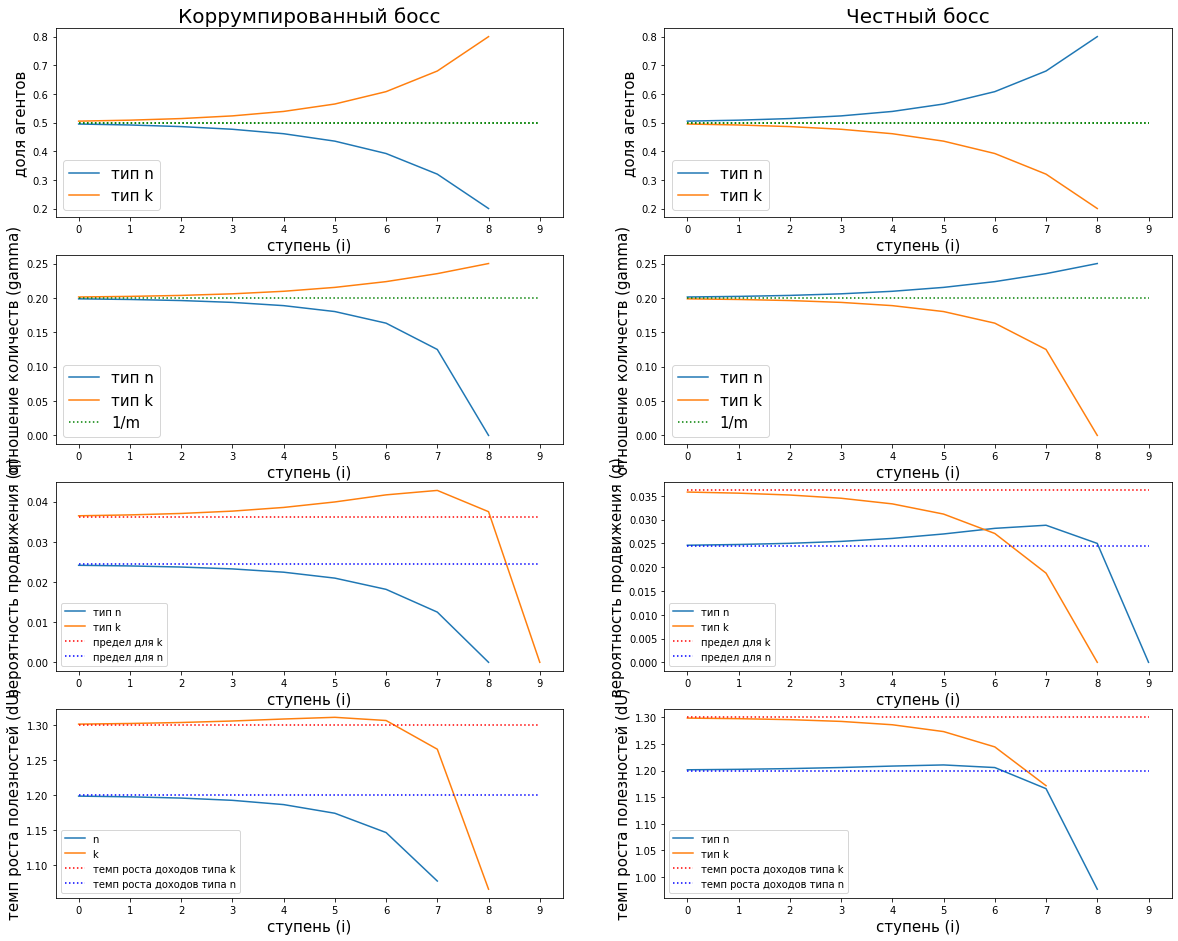

In [7]:
default_params = {
    'l':10, # кол-во ступеней
    'm':5, # число подчиненных у босса
    'alpha_k':0.8, # доля к-подчиненнных у к-босса
    'alpha_n':0.2, # доля к-подчинненных у н-босса
    'p_n':0.9, # вероятность не дожить до след периода для н-игрока
    'delta_p':0.05, # занижение вероятности не дожить до след периода для к-игрока (то есть delta_p = p_n - p_k)
    'lambda_n':1.2, # темп роста доходов у н-игроков
    'lambda_k':1.3, # темп роста доходов у к-игроков
}
m = Model(**default_params)
m.compute_model()
m.test_model()
m.plot_info()


In [3]:
from numpy.random import rand, randint

N = 100000
for _ in range(N):
    alpha_rand = rand()
    p_rand = rand()
    lambda_rand = rand()
    params = {
        'l': randint(2, 20), 
        'm': randint(2, 10),
        'alpha_k': alpha_rand, 
        'alpha_n': alpha_rand * rand(), 
        'p_n': p_rand, 
        'delta_p': p_rand * rand(), 
        'lambda_k': 1 + lambda_rand, 
        'lambda_n': 1 + lambda_rand * rand() , 
    }
    m = Model(**params)
    m.compute_model()
    m.test_model()
